# Software Bug Prediction

### Dataset:
The dataset is collected at the University of Geneva in Switzerland related to the bug prediction dataset. It contains data about the following software systems:
    - Eclipse JDT Core
    - Eclipse PDE UI
    - Equinox Framework
    - Lucene
    - Mylyn
    
### Objective:
Software success depends heavily on the ability of maintaining the software and ensuring that the software is released with minimal number of issues. Knowing in advance an estimation of possibile bugs in the software will mitagate some of the risks after the software is released. Our main objective is to be able to predict in advance the number of bugs in the software using the software data itself such as the number of lines of code, number of methods, number of attributes, and other important software properties. This is an overview of our objectives in details:
- Data Analysis
- Data preprocessing
- Data visualization
- Advanced EDA and visulaization using ML/D-reduction algorithms
- hyper-parameter tuning and solving the imbalance problem
    - Classifying data where the classes are: no bugs, 1 bug, or > 2 bugs
    - Classifying data where the classes are: no bugs, > 0 bugs

### Outline:
- import
- data cleaning
- EDA and visualization
    - descriptive statistics
    - correlation matrix
    - feature importance (Lasso)
    - feature importance (RFC)
    - kernal density estimation
    - 3D scatter cross plots
    - UMAP dimensionality reduction
    - PCA dimensionality reduction
    - clustering analysis
   
   
- Base Line Classifier
    - Accuacy
    - ROC
    - F-1 Score
    - Confusion Matrix
    - Area Under the Curve of ROC Viz
    
    
- first stage modeling
    - hyper-parameter tuning model optimization
    - dimensionality reduction
    
    
- evaluation
    - Accuacy
    - ROC
    - F-1 Score
    - Confusion Matrix
    - Area Under the Curve of ROC Viz
    
    
- second stage modeling (data-driven model optimization to tackle imbalance)
    - Under Sampling
    - Over Sampling
    - Feature Selection


- evaluation
    - Accuacy
    - ROC
    - F-1 Score
    
    
- models quality metrics table
    - Multi
        - Accuacy (All and Best)
        - ROC (All and Best)
        - F-1 Score (All and Best)
    - Binary
        - Accuacy (All and Best)
        - ROC (All and Best)
        - F-1 Score (All and Best)

In [52]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 5)

from sklearn.ensemble import BaggingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import AdaBoostClassifier


from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, f1_score

from sklearn.preprocessing import LabelBinarizer


from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import umap


# Import

In [53]:
eclipse_jdt = pd.read_csv("./data/Eclipse_ JDT_Core_single-version-ck-oo_bugs_only.csv")
eclipse_pdt = pd.read_csv("./data/Eclipse_PDE_UI_single-version-ck-oo_bug_only.csv")
equinox = pd.read_csv("./data/Equinox_Framework_single-version-ck-oo_bug_only.csv")
lucene = pd.read_csv("./data/Lucene_single-version-ck-oo_bug_only.csv")
mylyn = pd.read_csv("./data/Mylyn_single-version-ck-oo_bug_only.csv")

# Preprocessing & Analysis

In [54]:
print("NaNs in eclipse_jdt", np.sum(np.sum(eclipse_jdt.isna(), axis=0)) )
print("NaNs in eclipse_pdt", np.sum(np.sum(eclipse_pdt.isna(), axis=0)) )
print("NaNs in equinox", np.sum(np.sum(equinox.isna(), axis=0)) )
print("NaNs in lucene", np.sum(np.sum(lucene.isna(), axis=0)) )
print("NaNs in mylyn", np.sum(np.sum(mylyn.isna(), axis=0)) )

# drop nans
eclipse_pdt.dropna(axis = 1, inplace=True)
equinox.dropna(axis = 1, inplace=True)
lucene.dropna(axis = 1, inplace=True)
mylyn.dropna(axis = 1, inplace=True)

NaNs in eclipse_jdt 0
NaNs in eclipse_pdt 5988
NaNs in equinox 1296
NaNs in lucene 2764
NaNs in mylyn 7448


### Note: 
All Nans are added columns due to added commas (seperators) in each row

In [55]:
print("Data Shapes:", eclipse_jdt.shape, eclipse_pdt.shape, equinox.shape, lucene.shape, mylyn.shape)
df = pd.concat([eclipse_jdt, eclipse_pdt, equinox, lucene, mylyn], ignore_index=True)
df.columns = df.columns.str.replace(' ', '')
print("Full dataframe shape:",df.shape, '\n')
print("Predictors:")
for name in df.columns.values[1:18].tolist():
    print(name, end=', ')
print("\n\nPredictable:", df.columns.values[18])
df.head()

Data Shapes: (997, 20) (1497, 20) (324, 20) (691, 20) (1862, 20)
Full dataframe shape: (5371, 20) 

Predictors:
cbo, dit, fanIn, fanOut, lcom, noc, numberOfAttributes, numberOfAttributesInherited, numberOfLinesOfCode, numberOfMethods, numberOfMethodsInherited, numberOfPrivateAttributes, numberOfPrivateMethods, numberOfPublicAttributes, numberOfPublicMethods, rfc, wmc, 

Predictable: bugs


classname  cbo  dit  fanIn  fanOut  \
0  org::eclipse::jdt::internal::core::search::ind...    9    2      1       9   
1  org::eclipse::jdt::internal::compiler::codegen...    1    1      1       0   
2  org::eclipse::jdt::internal::compiler::ast::AS...  114    1    102      18   
3  org::eclipse::jdt::internal::compiler::lookup:...    5    6      1       4   
4  org::eclipse::jdt::internal::eval::CodeSnippet...   23    2      1      22   

   lcom  noc  numberOfAttributes  numberOfAttributesInherited  \
0    15    0                   1                            8   
1     0    0                   2                            0   
2   190    6                 131                          249   
3    10    0                   0                           61   
4   820    0                   7                          416   

   numberOfLinesOfCode  numberOfMethods  numberOfMethodsInherited  \
0                  122                6                        19   
1                    4                1                         8   
2                  484               20                         8   
3                   33                5                       207   
4                  673               41                         8   

   numberOfPrivateAttributes  numberOfPrivateMethods  \
0                          0                       0   
1                          0                       0   
2                          0                       1   
3                          0                       0   
4                          0                       2   

   numberOfPublicAttributes  numberOfPublicMethods  rfc  wmc  bugs     
0                         1                      5   34   20     0     
1                         2                      1    1    1     0     
2                         3                     19  156  176     1     
3                         0                      4   18   12     0     
4                         7                      1  174  115     0

In [56]:
df.describe()

cbo          dit        fanIn       fanOut          lcom  \
count  5371.000000  5371.000000  5371.000000  5371.000000   5371.000000   
mean      9.650717     1.948985     4.077825     5.808229    131.440328   
std      15.430910     1.339559    12.763334     7.413065   1419.297581   
min       0.000000     1.000000     0.000000     0.000000      0.000000   
25%       3.000000     1.000000     1.000000     1.000000      3.000000   
50%       6.000000     1.000000     1.000000     3.000000     15.000000   
75%      11.000000     2.000000     3.000000     8.000000     55.000000   
max     362.000000     9.000000   355.000000    93.000000  81003.000000   

               noc  numberOfAttributes  numberOfAttributesInherited  \
count  5371.000000         5371.000000                  5371.000000   
mean      0.548687            5.648110                    20.607522   
std       2.320663           32.421878                    75.447749   
min       0.000000            0.000000                     0.000000   
25%       0.000000            1.000000                     0.000000   
50%       0.000000            2.000000                     0.000000   
75%       0.000000            5.000000                     2.000000   
max      49.000000         2169.000000                   563.000000   

       numberOfLinesOfCode  numberOfMethods  numberOfMethodsInherited  \
count          5371.000000      5371.000000               5371.000000   
mean            119.126233         9.465649                 25.673245   
std             305.121926        13.519683                 40.646291   
min               0.000000         0.000000                  0.000000   
25%              18.000000         3.000000                  7.000000   
50%              47.000000         6.000000                 12.000000   
75%             115.000000        11.000000                 30.000000   
max            7509.000000       403.000000                602.000000   

       numberOfPrivateAttributes  numberOfPrivateMethods  \
count                5371.000000             5371.000000   
mean                    2.701545                1.515733   
std                     5.005445                4.259624   
min                     0.000000                0.000000   
25%                     0.000000                0.000000   
50%                     1.000000                0.000000   
75%                     3.000000                1.000000   
max                   103.000000              111.000000   

       numberOfPublicAttributes  numberOfPublicMethods          rfc  \
count               5371.000000            5371.000000  5371.000000   
mean                   1.588903               6.271272    47.397133   
std                   30.836387              10.583760   100.978959   
min                    0.000000               0.000000     0.000000   
25%                    0.000000               2.000000     8.000000   
50%                    0.000000               4.000000    21.000000   
75%                    0.000000               7.000000    51.000000   
max                 2168.000000             387.000000  2603.000000   

               wmc         bugs  
count  5371.000000  5371.000000  
mean     28.291380     0.259914  
std      69.140371     0.880067  
min       0.000000     0.000000  
25%       4.000000     0.000000  
50%      11.000000     0.000000  
75%      27.000000     0.000000  
max    1680.000000    28.000000

### Note: 
- Values in columns are distributed with high standard deviation compared to others -> Scaling is needed if a distance-based model is used, but not now on the whole dataset to prevent data leakage.
- We do not need confusing variables such as the class name; We can use it as an index or discard it.


In [57]:
# Shuffle data before removing classname to keep mapping
df = df.sample(frac=1.0)

# We do not need confusing variables such as the class name; We can use it as an index or leave it.
X = df.iloc[:, 1:-2]
y = df["bugs"]

print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


In [58]:
X.head()

cbo  dit  fanIn  fanOut  lcom  noc  numberOfAttributes  \
272     4    3      1       4   105    0                   5   
3355    2    1      1       1    28    0                  13   
4735    1    1      0       1     1    0                   1   
2081   19    3      1      18    91    0                   3   
5096    2    1      2       0     1    0                   4   

      numberOfAttributesInherited  numberOfLinesOfCode  numberOfMethods  \
272                            95                  109               15   
3355                            0                   53                8   
4735                            0                   11                2   
2081                            0                  142               14   
5096                            0                   22                2   

      numberOfMethodsInherited  numberOfPrivateAttributes  \
272                         73                          3   
3355                         9                          0   
4735                        18                          1   
2081                        21                          3   
5096                        26                          1   

      numberOfPrivateMethods  numberOfPublicAttributes  numberOfPublicMethods  \
272                        0                         0                      6   
3355                       0                         0                      4   
4735                       0                         0                      2   
2081                       6                         0                      7   
5096                       0                         0                      1   

      rfc  wmc  
272    55   28  
3355   16   21  
4735    4    4  
2081   79   19  
5096    3    6

In [59]:
X = df.iloc[:, 1:-2]
y = df["bugs"]

print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


### Make Classes [0, 1, 2] Bugs

for Multi-classifiers; we will start with Task 2 first

In [60]:
# Warning: Don't Run Twice
y = y.replace(y.where(y > 2), 2)

In [61]:
print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


In [62]:
((y.index == X.index).sum())

5371

### Class Balance

Classes: [0, 1, 2]
Counts: [4518, 598, 255]


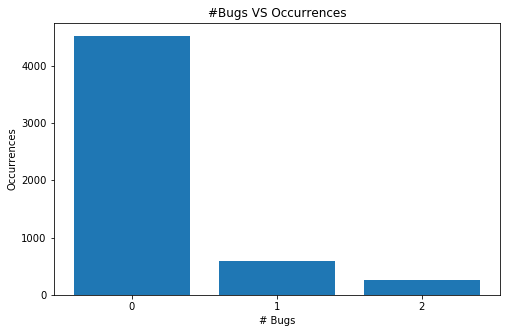

In [63]:
unique, counts = np.unique(y, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

### Note: 
Based on these class balances, we have to be careful not to overfit or make the classifier favors "Class 0" unfairly

# More EDA on Training Set

### Note: 
It is better to Leave-One-Out and do the EDA & some transoformational preprocessing so that we do not use our intuition and analysis from the test set  and be fooled by a high accuracy on a set that we have prepared our model for.

###### Example: 
Feature Selection that is done on the whole dataset is a very pure data leakage. Your test set is not a test set if the model has already known what are the best features to use as predictors of the target value

###### Example: 
Dimensionality reduction (such as PCA) that is done one the whole dataset means that you have leaked distributional information from the test set to the training set (e.g. Variance). 

###### Example: 
Scaling the dataset as a whole is needed but when you use the whole dataset for fitting the scalar, then data leakage has occured, if a blueprint dataset factor (e.g. variance, mean, minimum, maximum) is used

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5)
print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

Train: (3759, 17) (3759,) Test: (806, 17) (806,) Cross Validation (806, 17) (806,)


Let's make sure that we have a similar class balance distribution

In [65]:
unique, counts = np.unique(y_train, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

Classes: [0, 1, 2]
Counts: [3168, 421, 170]


##### Scaling Features

In [77]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

data_for_viz = X_train_scaled.copy()
data_for_viz_unscaled = X_train.copy()

data_for_viz['Bugs'] = y_train.copy().tolist()
data_for_viz_unscaled['Bugs'] = y_train.copy().tolist()

In [67]:
data_for_viz.head()

cbo       dit     fanIn    fanOut      lcom       noc  \
4969 -0.632778 -0.709295 -0.323547 -0.778099 -0.083466 -0.232648   
2328 -0.368818 -0.709295 -0.243248 -0.240389 -0.070386 -0.232648   
4731 -0.368818 -0.709295 -0.243248 -0.374817 -0.082843 -0.232648   
1558 -0.236838  0.029276 -0.243248 -0.105961 -0.079728 -0.232648   
4774 -0.566788 -0.709295 -0.323547 -0.643672 -0.082843 -0.232648   

      numberOfAttributes  numberOfAttributesInherited  numberOfLinesOfCode  \
4969            3.232217                    -0.276344            -0.355501   
2328           -0.099733                    -0.276344            -0.168788   
4731           -0.126177                    -0.276344            -0.337432   
1558           -0.046845                    -0.276344            -0.207938   
4774           -0.152621                    -0.276344            -0.334421   

      numberOfMethods  numberOfMethodsInherited  numberOfPrivateAttributes  \
4969        -0.608087                 -0.618416                  -0.335009   
2328        -0.172282                 -0.428848                  -0.131404   
4731        -0.535453                 -0.405152                  -0.335009   
1558        -0.390184                  0.045072                   0.072202   
4774        -0.535453                 -0.618416                  -0.538615   

      numberOfPrivateMethods  numberOfPublicAttributes  numberOfPublicMethods  \
4969               -0.350456                  3.451719              -0.484561   
2328               -0.114073                 -0.047445              -0.017782   
4731               -0.350456                 -0.047445              -0.391206   
1558               -0.350456                 -0.047445              -0.391206   
4774               -0.350456                 -0.047445              -0.391206   

           rfc       wmc  Bugs  
4969 -0.427381 -0.380501     1  
2328 -0.080626 -0.130365     0  
4731 -0.371150 -0.366604     0  
1558 -0.277433 -0.338812     0  
4774 -0.408637 -0.352708     0

#### Correlation Matrix

In [68]:
fig, ax = plt.subplots(figsize=(10,8))

corr = data_for_viz.corr()
mask = np.triu(corr)
sns.heatmap(corr, vmin=-1, vmax=1, center= 0, cmap= 'Pastel2', linewidths=3, ax=ax, mask=mask);

###### We can see that highest correlated variables with Bugs are: 
1. cbo
    - is correlated with fanIn
    - is correlated with fanOut
2. fanout
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfLinesOfCode
    - is correlated with numberOfMethods
3. numberOfLinesOfCode
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfMethods
4. numberOfMethods
    - is correlated with wmc
    - is correlated with rfc
    - is correlated with numberOfPublicMethods
    
    - .
    - .
    - .
    

#### To sum up: There is a high correlation between: 
    - Bugs
    - cbo
    - fanout
    - fanIn
    - wmc
    - rfc
    - numberOfLinesOfCode
    - numberOfMethods
    - numberOfPublicMethods
    - numberOfPrivateMethods

### Feature importance with Lasso regression

In [69]:
lasso = Lasso()
lasso.fit(X_train,y_train)
coef = pd.Series(lasso.coef_, index = X_train.columns)

print("Discarded Features:", np.sum(lasso.coef_==0), "out of", len(X_train.columns))

Discarded Features: 11 out of 17


In [70]:
coef = coef[coef != 0]

In [71]:
coef.sort_values().plot(kind='barh', cmap="Pastel2");

### Feature importance with Random Forest Classifier

In [72]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train);
coef_rfc = pd.Series(rfc.feature_importances_, index = X_train.columns)

In [73]:
preds = rfc.predict(X_train)
print("accuracy score:", accuracy_score(y_train, preds))

accuracy score: 0.99707368981112


### Note: 
of course, the accuracy is going to be high on the same set that was trained on, we are just making sure that it has done a good job on predicting the training set and thus giving an accurate prediction of important features **based on the training set**

In [74]:
coef_rfc.sort_values()[7:].plot(kind='barh', cmap="Pastel2");

#### Pick Features for DataViz
Let's now pick a couple of important features from our analysis with correlation matrix, lasso regression feature importance, and random forest classifier feature importance, we will go with:
    - rfc
    - cbo
    - fanOut
    - wmc
    - numberOfLinesOfCode
#### As these features are the most effective ones as predictors over our analysis
# Data Visualization   

In [78]:
data_for_viz_unscaled.head()

cbo  dit  fanIn  fanOut  lcom  noc  numberOfAttributes  \
4969    0    1      0       0     0    0                 128   
2328    4    1      1       4    21    0                   2   
4731    4    1      1       3     1    0                   1   
1558    6    2      1       5     6    0                   4   
4774    1    1      0       1     1    0                   0   

      numberOfAttributesInherited  numberOfLinesOfCode  numberOfMethods  \
4969                            0                    3                1   
2328                            0                   65                7   
4731                            0                    9                2   
1558                            0                   52                4   
4774                            0                   10                2   

      numberOfMethodsInherited  numberOfPrivateAttributes  \
4969                         0                          1   
2328                         8                          2   
4731                         9                          1   
1558                        28                          3   
4774                         0                          0   

      numberOfPrivateMethods  numberOfPublicAttributes  numberOfPublicMethods  \
4969                       0                       127                      1   
2328                       1                         0                      6   
4731                       0                         0                      2   
1558                       0                         0                      2   
4774                       0                         0                      2   

      rfc  wmc  Bugs  
4969    2    1     1  
2328   39   19     0  
4731    8    2     0  
1558   18    4     0  
4774    4    3     0

#### Pair Plots (Scatter)

In [79]:
for_pair_plot = data_for_viz_unscaled[['rfc', 'cbo', 'fanOut','wmc', 'numberOfLinesOfCode', 'Bugs']]
sns.pairplot(for_pair_plot, hue="Bugs", vars=['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']);

### Kernal Density of Classes w.r.t one variable

In [119]:
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'rfc'], color='red', shade=True, Label='0 Bugs') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'rfc'], color='blue', shade=True, Label='1 Bug') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'rfc'], color='orange', shade=True, Label='2 Bugs') 

plt.xlabel('Request for Comments/Change - rfc') 
plt.ylabel('Probability Density')
plt.title("Request for Comments/Change - rfc & Class Probability Density")

plt.xlim(-100, 1000);

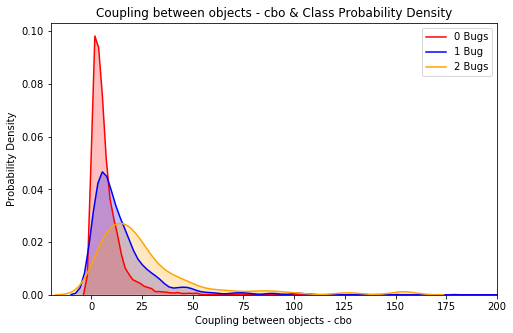

In [120]:
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'cbo'], color='red', shade=True, Label='0 Bugs') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'cbo'], color='blue', shade=True, Label='1 Bug') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'cbo'], color='orange', shade=True, Label='2 Bugs') 

plt.xlabel('Coupling between objects - cbo') 
plt.ylabel('Probability Density')
plt.title("Coupling between objects - cbo & Class Probability Density")

plt.xlim(-20, 200);

In [121]:
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'fanOut'], color='red', shade=True, Label='0 Bugs') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'fanOut'], color='blue', shade=True, Label='1 Bug') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'fanOut'], color='orange', shade=True, Label='2 Bugs') 

plt.xlabel('Fan-Out - fanOut') 
plt.ylabel('Probability Density')
plt.title("Fan-Out - fanOut & Class Probability Density")

plt.xlim(-20, 75);

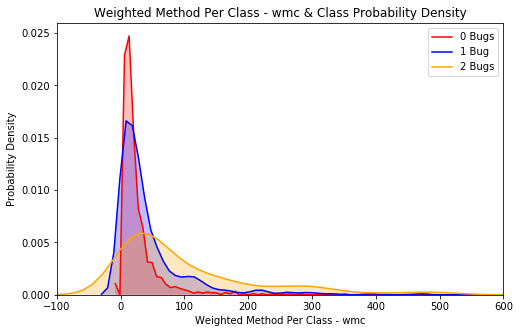

In [122]:
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'wmc'], color='red', shade=True, Label='0 Bugs') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'wmc'], color='blue', shade=True, Label='1 Bug') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'wmc'], color='orange', shade=True, Label='2 Bugs') 

plt.xlabel('Weighted Method Per Class - wmc') 
plt.ylabel('Probability Density')
plt.title("Weighted Method Per Class - wmc & Class Probability Density")

plt.xlim(-100, 600);

In [118]:
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 0), 'numberOfLinesOfCode'], color='red', shade=True, Label='0 Bugs') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 1), 'numberOfLinesOfCode'], color='blue', shade=True, Label='1 Bug') 
sns.kdeplot(data_for_viz_unscaled.loc[(data_for_viz_unscaled['Bugs'] == 2), 'numberOfLinesOfCode'], color='orange', shade=True, Label='2 Bugs') 

plt.xlabel('numberOfLinesOfCode') 
plt.ylabel('Probability Density')
plt.title("numberOfLinesOfCode & Class Probability Density")
plt.xlim(-500, 2000);

#### Scatter 3D Cross Plot

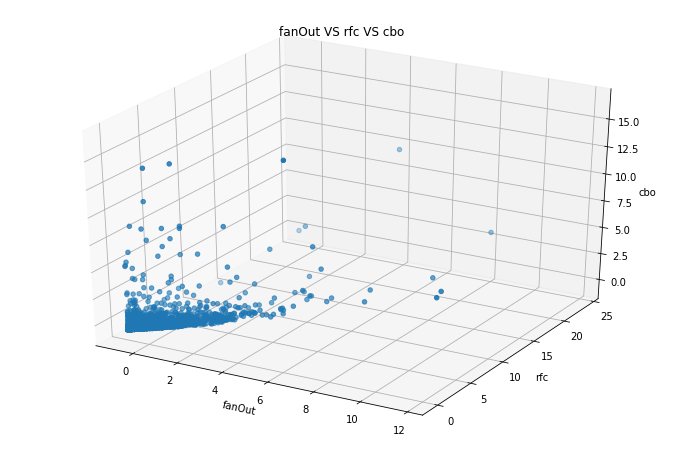

In [129]:
cross_plot1 = plt.figure(figsize=(12,8)).gca(projection='3d')
cross_plot1.scatter(data_for_viz['fanOut'], data_for_viz['rfc'], data_for_viz['cbo'])
cross_plot1.set_xlabel('fanOut')
cross_plot1.set_ylabel('rfc')
cross_plot1.set_zlabel('cbo')
cross_plot1.set_title("fanOut VS rfc VS cbo");

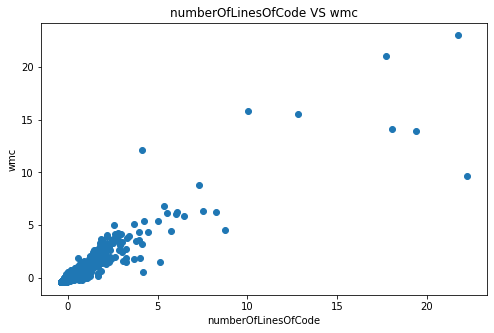

In [132]:

plt.scatter(data_for_viz['numberOfLinesOfCode'], data_for_viz['wmc'])
plt.xlabel('numberOfLinesOfCode')
plt.ylabel('wmc')
plt.title("numberOfLinesOfCode VS wmc");

# Clustering Analysis
### UMAP Dimensionality reduction algorithm
This is an alogorithm that was developed in 2018 which competes with state-of-the-art dimensionality reduction algorithms in its fast execution performance and the ability to project the dimensions without losing a lot of information. 

Feel free to explore benchmarking against other algorithms here: 
https://umap-learn.readthedocs.io/en/latest/benchmarking.html

*McInnes, Leland, Healy, John, & James. (2018, December 06). UMAP: Uniform Manifold Approximation and Projection for Dimension Reduction. Retrieved from https://arxiv.org/abs/1802.03426*

In [30]:
reducer = umap.UMAP(verbose=False)
embedding = reducer.fit_transform(X_train_scaled)
embedding.shape

(3759, 2)

In [31]:
embedding = pd.DataFrame(embedding)
embedding.head()

0         1
0 -1.001042 -3.540053
1 -0.425117 -4.456758
2 -1.808464 -4.692741
3  0.311770 -1.891203
4  8.122357 -3.292733

#### Next plot is colored by K-Means predictions

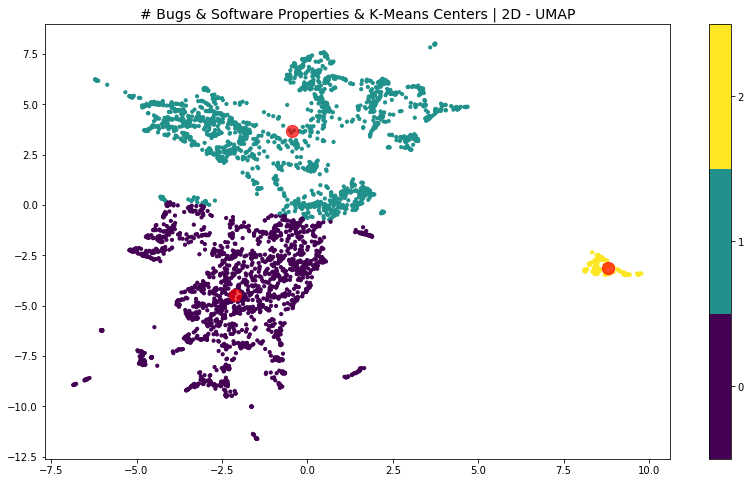

In [32]:
kmeans_umap = KMeans(n_clusters=3)
kmeans_umap.fit(embedding)
preds_kmeans_umap = kmeans_umap.predict(embedding)

fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(embedding[0], embedding[1], c=preds_kmeans_umap, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(preds_kmeans_umap))

plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

plt.title('# Bugs & Software Properties & K-Means Centers | 2D - UMAP', fontsize=14);

In [33]:
print("K-Means Accuracy Score:", accuracy_score(preds_kmeans_umap, y_train))

K-Means Accuracy Score: 0.48417132216014896


### Note: 
This accuracy on the training set is not a surprise! Take a look at the plot below.

Note that there is no relationship between the number of bugs and the clusters set by K-Means predictor. 0,1, and 2 in the plot are just the specified number of clusters for K-Means.

To clarify the confusion
#### Next Plot is colored by actual values (y_train) and K-Means centers are included

In [34]:
fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(embedding[0], embedding[1], c=y_train, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(y_train))

plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

plt.title('# Bugs & Software Properties & K-Means Centers | 2D - UMAP', fontsize=14);

### PCA Dimensionality reduction algorithm

#### Next plot is colored by actual values (y_train)
#### Note:
The plot was zoomed due to extreme outliers

In [35]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)

principalComponents = pd.DataFrame(principalComponents)

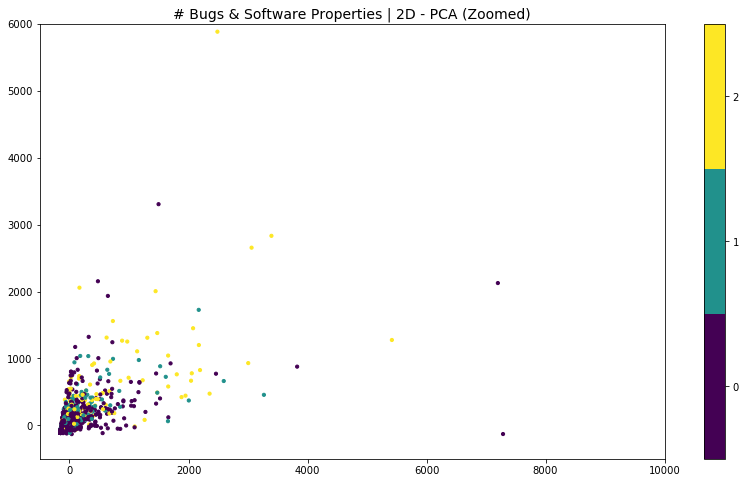

In [36]:
fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(principalComponents[0], principalComponents[1], c=y_train, s=10, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(y_train))
ax.set_xlim(-500, 10000);
ax.set_ylim(-500, 6000);

plt.title('# Bugs & Software Properties | 2D - PCA (Zoomed)', fontsize=14);

#### Next Plot is colored by K-Means cluster predictions and not actual values (y_train)

K-Means Accuracy Score Using PCA: 0.8480978983772279


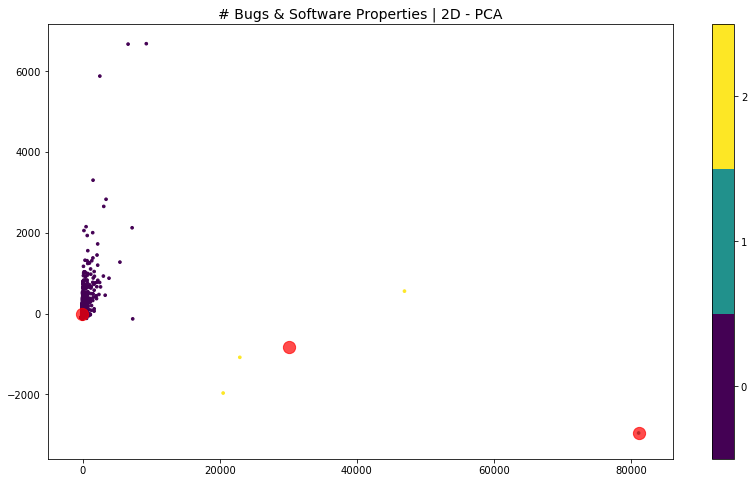

In [37]:
kmeans_pca = KMeans(n_clusters=3)
kmeans_pca.fit(principalComponents)
preds_kmeans_pca = kmeans_pca.predict(principalComponents)

fig, ax = plt.subplots(figsize=(14,8))

plt.scatter(principalComponents[0], principalComponents[1], c=preds_kmeans_pca, s=7, cmap='viridis')
cbar = plt.colorbar(boundaries=np.arange(4)-0.5)
cbar.set_ticks(np.arange(3))
cbar.set_ticklabels(np.unique(preds_kmeans_pca))

plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], c='red', s=150, alpha=0.7);

# ax.set_xlim(-500, 10000);
# ax.set_ylim(-500, 6000);

plt.title('# Bugs & Software Properties | 2D - PCA', fontsize=14);

print("K-Means Accuracy Score Using PCA:", accuracy_score(preds_kmeans_pca, y_train))

### Note
It is obvious to spot that K-Means had a high accuracy on the training set but definitely not a generalizable one not just because it's on the training set but mainly, for our analysis, it has almost excluded a whole class (**Recall: Notes on class balances in the dataset**) if we took a look at the actualy distribution of classes when if was plotted by actual values after PCA reduction and now with the predicted values from K-Means

# Modeling 

#### Models:
- For Multi-Class Classification
    - Random Forest Classifier (Ensemble)
    - K-Nearest Neighbor
    - K-Means (Clustering)

- For Binary Classification
    - AdaBoost (Boosting)
    - Support-Vector Machine
    - Bagging Classifier

- Neural Network (FCNN)

All of these models either:
- need scaling for better generalized results (i.e. SVC, KNN, KMeans, FCNN) as they are distance-based where they are affected by outliers and more importantly (in our case) might favor one feature against another.
- not affected by scaling if the weak learner is a tree-based classifier for AdaBoost, Bagging, or RFC

#### Scale Features seperately in each dataset (NOT the cross validation one; cv dataset should be scaled with each fold in hyper-parameter tuning)

In [38]:
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

Train: (3759, 17) (3759,) Test: (806, 17) (806,) Cross Validation (806, 17) (806,)


#### Modeling Function

In [39]:
def Modeler(model, X_train, y_train, X_cv, y_cv, params, scale=True, n_jobs=True, pca=False):
    
    if scale & pca:
        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('dim_reduct', PCA(n_components=4)),
            ('clf', model())])
        print("Scaling and dim reduct...")
        
    elif scale:
        pipeline = Pipeline([ ('scale', StandardScaler()), ('clf', model())])
        
    elif pca:
        pipeline = Pipeline([
        ('dim_reduct', PCA(n_components=pca)),
        ('clf', model())])
    else:
        pipeline = Pipeline([('clf', model())])
        
    grid = GridSearchCV(pipeline, param_grid = params, cv=3, n_jobs=4, refit=True)
    grid.fit(X_cv, y_cv)
    
    best_prameters = {}
    for k, v in grid.best_params_.items():
        best_prameters[k[5:]] = v

    if n_jobs:
        model = model(**best_prameters, n_jobs=4)
    else:
        model = model(**best_prameters)
   
    model.fit(X_train, y_train)
    
    print("Best Parameters for model:", best_prameters)

    return {
        "model": model, 
        "best_params":best_prameters
    }

#### Evaluator Function

#### Note 
- We will value all classes in the same way without any dominance from one class on the metric. Therefore, we will use Macro-Averaging for both ROC and F1-Score. This will tell us that our scores will be much lower than expected due to the imbalance (**More details on that at the end**)
- We can use AUCROC by one-vs-all Technique

In [40]:
def model_eval(model, X_test, y_test, acc=True, auc_=True, plot_conf=True, plot_auc=True, multi=True, f1=True, prop=False):
    
    res = [None, None, None] # Accuracy, auc_roc, f1_score
    y_pred = model.predict(X_test)
    
    if prop:
        y_pred = np.where(y_pred > 0.5, 1, 0)
    
    if f1:
        f_sc = f1_score(y_test, y_pred, average='macro')
        res[2] = f_sc
        
    if acc:
        res[0] = accuracy_score(y_test, y_pred)
#         print('accuracy:', res[0] * 100 ,'%')

    if auc_:
        lb = LabelBinarizer()
        lb.fit(y_test)

        truth = lb.transform(y_test)
        y_pred_encode = lb.transform(y_pred)

        res[1] = roc_auc_score(truth, y_pred_encode, average = 'macro')
#         print('ROC:', res[1] * 100 ,'%')

    if plot_conf:
        fig, ax = plt.subplots(figsize=(10,6))

        conf = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
        sns.heatmap(conf, cmap= 'Set1', annot=True, cbar=False)
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.title('Confusion Matrix');
    
    if plot_auc:
        fig, ax = plt.subplots(figsize=(10,6))

        if not auc_:
            lb = LabelBinarizer()
            lb.fit(y_test)

            truth = lb.transform(y_test)
            y_pred_encode = lb.transform(y_pred)

        fpr = [None, None, None]
        tpr = [None, None, None]
        auc_of_roc = [None, None, None]
        
        n_classes = 1 #(0, 1)
        if multi:
            n_classes = 3
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(truth[:, i], y_pred_encode[:, i])
            auc_of_roc[i] = auc(fpr[i], tpr[i])
            
        plt.plot(fpr[0], tpr[0], label='0 - area under ROC = %0.3f' % auc_of_roc[0])
        if multi:
            plt.plot(fpr[1], tpr[1], label='1 - area under ROC = %0.3f' % auc_of_roc[1])
            plt.plot(fpr[2], tpr[2], label='2 - area under ROC = %0.3f' % auc_of_roc[2])

        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC AUC");
        plt.legend()

    return res


#### Under Sampler Function

In [44]:
def under_sample(X_train, y_train, n=573):
    train_ = pd.concat([X_train, y_train], axis=1)
    df_0 = train_[train_.iloc[:, -1] == 0].sample(n= n)
    df_1 = train_[train_.iloc[:, -1] == 1].sample(n= n)

    train_ = pd.concat([df_0, df_1], axis=0).sample(frac=1.0)
    X_train_under_sampled = train_.iloc[:, 0:-1]
    y_train_under_sampled = train_.iloc[:, -1]
    return X_train_under_sampled, y_train_under_sampled

## Base-Line Classifier
We have to give a better accuracy or roc if we want our classifier to be better than a mere guessing

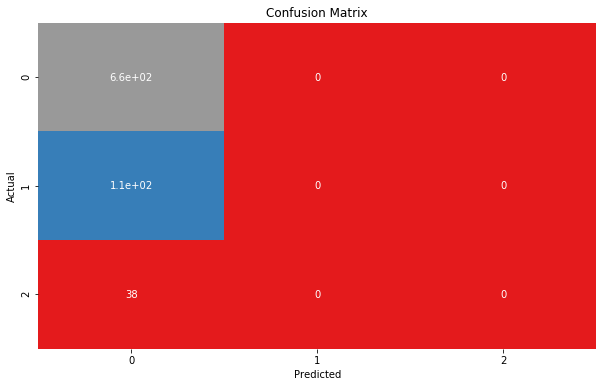

In [48]:
dmc = DummyClassifier(strategy="most_frequent")
dmc.fit(X_train_scaled, y_train)

model_scoring = model_eval(dmc, X_test_scaled, y_test)

scores = {}
scores["Dummy Classifier | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

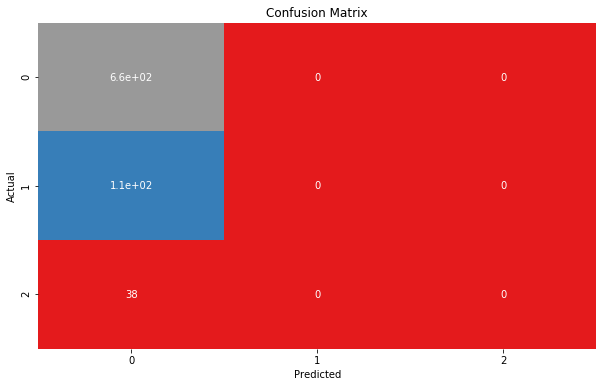

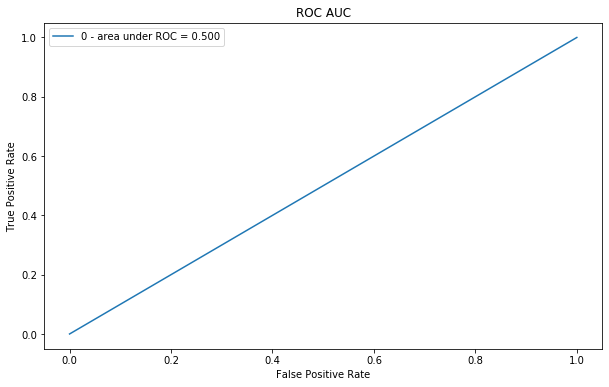

In [49]:
dmc = DummyClassifier(strategy="most_frequent")
dmc.fit(X_train_scaled, y_train)

model_scoring = model_eval(dmc, X_test_scaled, y_test, multi=False)

scores["Dummy Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

## Multi-Classifiers

### Random Forest Classifier

In [52]:
rfc_params = {
    'clf__n_estimators'      : [200, 500, 1000],
    'clf__max_depth'         : [10, 20, 50],
    'clf__max_features': [1.0, 0.7, 0.4],
    'clf__criterion' :['gini', 'entropy']
}

rfc = Modeler(RandomForestClassifier, X_train_scaled, y_train, X_cv, y_cv, rfc_params, scale=True) 

Best Parameters for model: {'criterion': 'entropy', 'max_depth': 50, 'max_features': 0.4, 'n_estimators': 500}


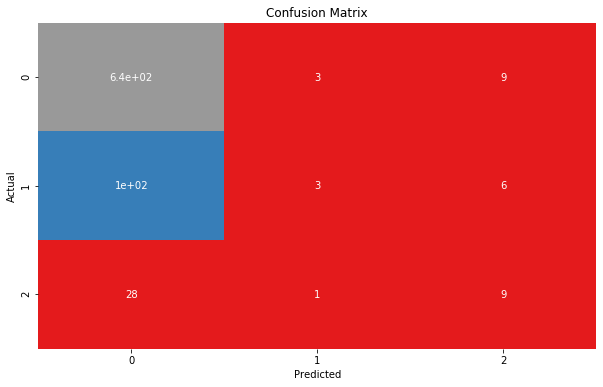

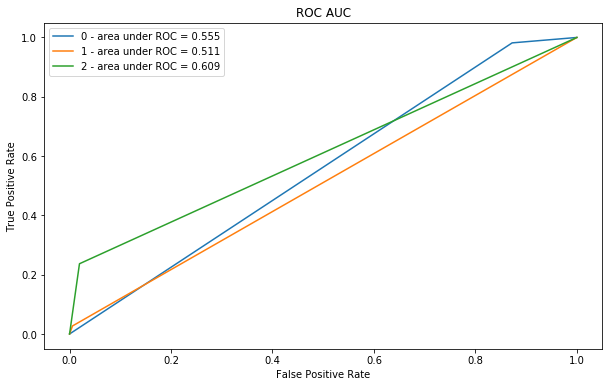

In [53]:
model_scoring = model_eval(rfc["model"], X_test_scaled, y_test)
scores["Random Forest | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### K-Nearest Neighbor

In [54]:
knn_params = {
    'clf__n_neighbors': [3, 5, 11, 17], # Try not to put even numbers
    'clf__weights': ['uniform', 'distance'],
    'clf__metric': ['euclidean', 'manhattan'],
}

knn = Modeler(KNeighborsClassifier, X_train_scaled, y_train, X_cv, y_cv, knn_params, scale=True)

Best Parameters for model: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'distance'}


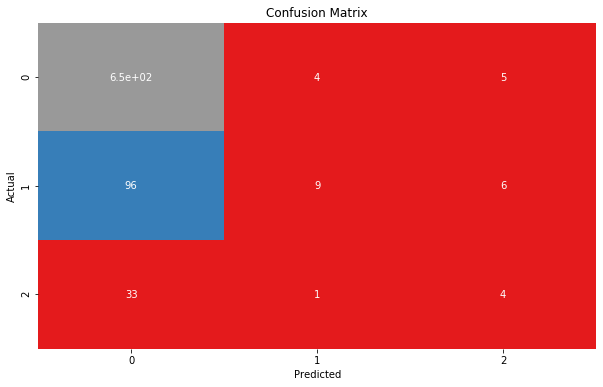

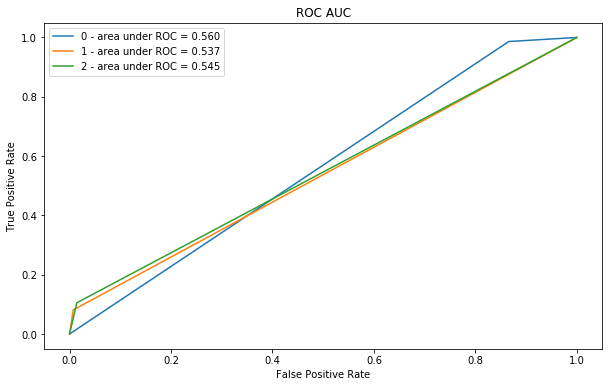

In [55]:
model_scoring = model_eval(knn["model"], X_test_scaled, y_test)
scores["K-Nearest Neighbor | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

In [56]:
kmeans_params = {
    'clf__max_iter': [200, 500, 1000], # Try not to put even numbers
    'clf__n_init': [10, 30]
}

kmeans = Modeler(KMeans, X_train_scaled, y_train, X_cv, y_cv, kmeans_params, scale=True)

Best Parameters for model: {'max_iter': 200, 'n_init': 10}


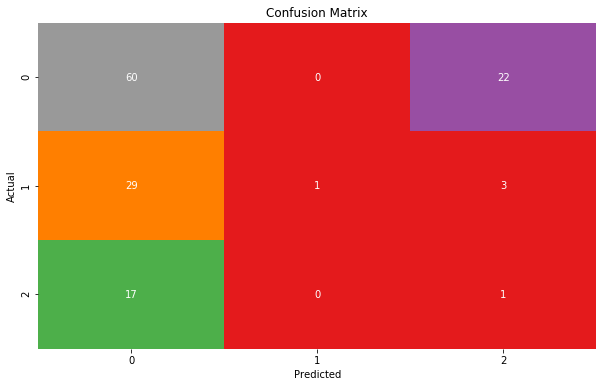

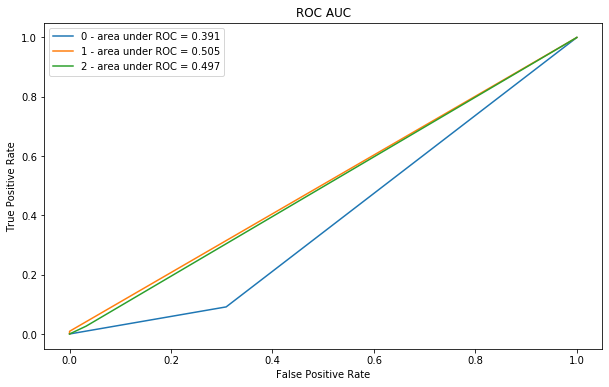

In [57]:
model_scoring = model_eval(kmeans["model"], X_test_scaled, y_test)
scores["K-Means | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}


### Bagging Classifier (Extra for multi-class)

In [58]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.3}


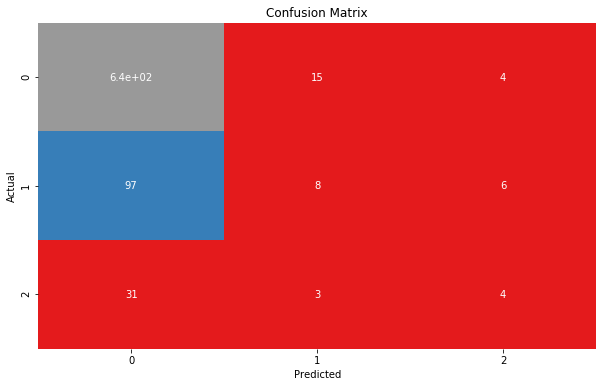

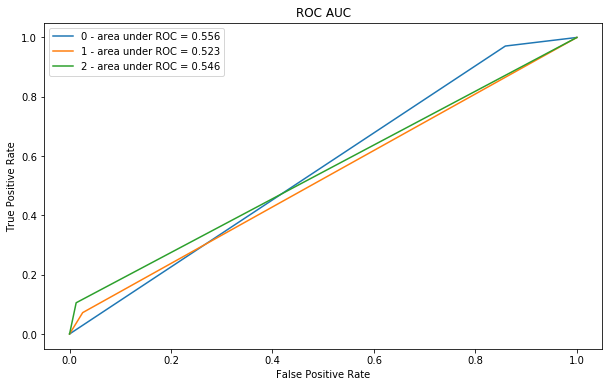

In [59]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test)
scores["Bagging Classifier | Multi"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Bagging Classifier (with PCA 4D)

In [60]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True, pca=4)


Best Parameters for model: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 0.5}


[0.7915632754342432, 0.5398085587777093, 0.38246428186731257]

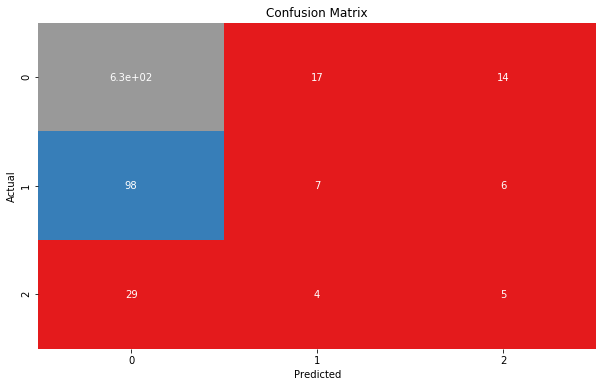

In [61]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test)

scores["Bagging Classifier | Multi | PCA"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

## Binary-Classifiers

In [62]:
# We do not need confusing variables such as the class name; We can use it as an index or leave it.
X_binary = df.iloc[:, 1:-2]
y_binary = df["bugs"]

# Warning: Don't Run Twice
y_binary = y_binary.replace(y_binary.where(y_binary > 1), 1)

print("X:", X.shape)
print("y:", y.shape)

X: (5371, 17)
y: (5371,)


In [63]:
unique, counts = np.unique(y_binary, return_counts=True)
print("Classes:", unique.tolist())
print("Counts:", counts.tolist())

plt.bar(unique, counts)
plt.title("#Bugs VS Occurrences")
plt.xticks(range(len(unique)))
plt.ylabel("Occurrences")
plt.xlabel("# Bugs");

Classes: [0, 1]
Counts: [4518, 853]


In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_binary, y_binary, test_size=0.3)
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5)
print("Train:", X_train.shape, y_train.shape,
      "Test:", X_test.shape, y_test.shape,
      "Cross Validation", X_cv.shape, y_cv.shape)

X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test.values), columns=X_test.columns, index=X_test.index)

Train: (3759, 17) (3759,) Test: (806, 17) (806,) Cross Validation (806, 17) (806,)


#### Warning: X_train, X_test,..., y_cv. has been overridden

### AdaBoost

In [65]:
# AdaBoostClassifier
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled, y_train, X_cv, y_cv, ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [66]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False)
scores["AdaBoost Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Support-Vector Machine

In [67]:
# SVC()
svc_params = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma':[1, 0.01, 0.001]
}

svc = Modeler(SVC, X_train_scaled, y_train, X_cv, y_cv, svc_params, scale=True, n_jobs=False)

Best Parameters for model: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


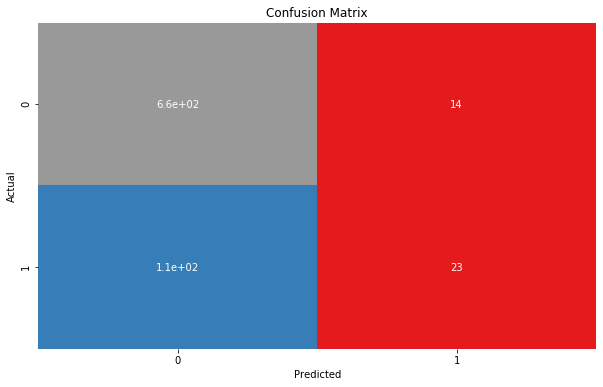

In [68]:
model_scoring = model_eval(svc["model"], X_test_scaled, y_test, multi=False)
scores["Support-Vector Machine | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

### Bagging Classifier

In [69]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled, y_train, X_cv, y_cv, bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 0.5}


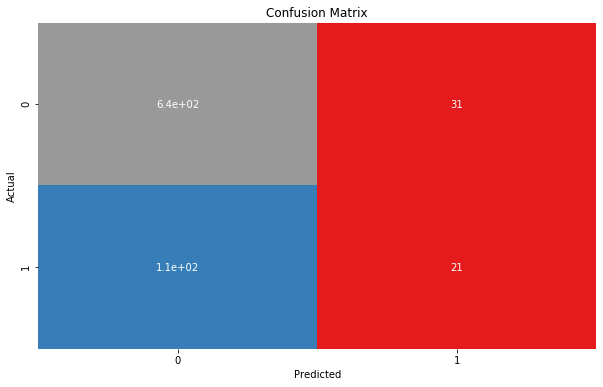

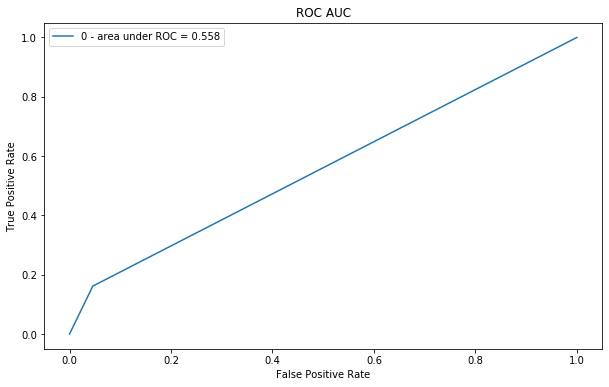

In [70]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False)
scores["Bagging Classifier | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

## Neural Network

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


Using TensorFlow backend.


In [72]:
def nn_modeler(input_dim, layer_1_dim, layer_2_dim, lr, out):
    model = Sequential()
    model.add(Dense(layer_1_dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(layer_2_dim, activation='relu'))
    model.add(Dense(out, activation='sigmoid'))
    SGD = optimizers.SGD(lr=lr)

    model.compile(loss='binary_crossentropy', optimizer = SGD)
    return model

In [75]:
from sklearn.model_selection import StratifiedKFold

NN_scores = {}
n_split=3
epochs = [30, 50] # Take a lot of time
batch_sizes = [32, 64] # Take a lot of time
first_layers = [30, 50]
second_layers = [10, 20]
lrs = [0.001, 0.1]
iters = 0
for epoch in epochs:
    for batch_size in batch_sizes:
        for first_layer in first_layers:
            for second_layer in second_layers:
                for lr in lrs:
                    # K-FOLDS
                    fcnn = None
                    accs = []
                    aurocs = []
                    f1s = []
                    for train_indicies, test_indicies in StratifiedKFold(n_split).split(X_cv, y_cv):
                        X_train_fold, y_train_fold, X_test_fold, y_test_fold = X_cv.iloc[train_indicies], y_cv.iloc[train_indicies], X_cv.iloc[test_indicies], y_cv.iloc[test_indicies]
                        X_train_fold = pd.DataFrame(StandardScaler().fit_transform(X_train_fold.values), columns=X_train_fold.columns, index=X_train_fold.index)
                        X_test_fold = pd.DataFrame(StandardScaler().fit_transform(X_test_fold.values), columns=X_test_fold.columns, index=X_test_fold.index)

                        fcnn = nn_modeler(17, first_layer, second_layer, lr, 1)
                        fcnn.fit(X_train_fold, y_train_fold, epochs=epoch, batch_size=batch_size, verbose=False)
                        model_scoring = model_eval(fcnn, X_test_scaled, y_test, plot_auc=False, plot_conf=False, prop=True)
                        accs.append(model_scoring[0])
                        aurocs.append(model_scoring[1])
                        f1s.append(model_scoring[2])
                    
                    info = "ep:" + str(epoch) + " bs:" + str(batch_size) + " f_lyr:" + str(first_layer) + " s_lyr:" + str(second_layer) + " lr:" + str(lr)

                    NN_scores[info] = {"Accuracy": np.mean(accs), "ROC": np.mean(aurocs), "F1": np.mean(f1s)}
                    iters +=1
                    print(str(iters) +'..', end='')

1..2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..

In [76]:
NN_scores = pd.DataFrame.from_dict(NN_scores).T
NN_scores = NN_scores.sort_values('ROC', ascending=False)

In [77]:
NN_scores.iloc[:10,:]

Accuracy       ROC        F1
ep:30 bs:32 f_lyr:50 s_lyr:10 lr:0.1  0.850289  0.609418  0.634376
ep:50 bs:32 f_lyr:50 s_lyr:20 lr:0.1  0.850703  0.605523  0.629998
ep:30 bs:32 f_lyr:30 s_lyr:20 lr:0.1  0.849462  0.603748  0.627612
ep:50 bs:32 f_lyr:30 s_lyr:20 lr:0.1  0.844913  0.598964  0.619995
ep:50 bs:64 f_lyr:50 s_lyr:20 lr:0.1  0.847395  0.593195  0.614819
ep:30 bs:64 f_lyr:50 s_lyr:20 lr:0.1  0.847808  0.592406  0.613290
ep:50 bs:64 f_lyr:30 s_lyr:20 lr:0.1  0.846567  0.589596  0.610000
ep:50 bs:64 f_lyr:30 s_lyr:10 lr:0.1  0.846154  0.589349  0.608987
ep:50 bs:64 f_lyr:50 s_lyr:10 lr:0.1  0.842018  0.588955  0.607403
ep:30 bs:64 f_lyr:50 s_lyr:10 lr:0.1  0.846567  0.584418  0.603222

##### Best Params

- Epochs: 30
- Batch Size: 32
- First Hidden Layer neurons: 50
- Second Hidden Layer neurons: 10
- Learning Rate: 0.1

In [78]:
fcnn = nn_modeler(17, 50, 10, 0.1, 1)
fcnn.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=False)

model_scoring = model_eval(fcnn, X_test_scaled, y_test, plot_auc=False, plot_conf=False, prop=True)


scores["Neural Network | Binary"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}

#### Note:
All models achieved a similar or less auc rocs/f1 without scaling (tried it for a sanity check)

In [79]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [80]:
score_df

Accuracy       ROC  F1-Score
Neural Network | Binary           0.841191  0.610207  0.631506
AdaBoost Classifier | Binary      0.844913  0.587574  0.607223
Support-Vector Machine | Binary   0.849876  0.578107  0.595856
Random Forest | Multi             0.815136  0.557972  0.414003
Bagging Classifier | Binary       0.826303  0.557840  0.566434
K-Nearest Neighbor | Multi        0.820099  0.547559  0.399570
Bagging Classifier | Multi        0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA  0.791563  0.539809  0.382464
Dummy Classifier | Multi          0.815136  0.500000  0.299385
Dummy Classifier | Binary         0.815136  0.500000  0.299385
K-Means | Multi                   0.076923  0.464229  0.029483

# Data-Driven Model Optimization

##### Pick the 3 highest models

## Under Sampling

Redcuing the number of samples in the majority class randomly so that the two classes are balanced and then testing it on an imbalanced real-world-like dataset (test set)

#### Neural Network

This modle was also trained on a PCAed training set with/out under-sampling

In [81]:
X_train_under_sampled, y_train_under_sampled = under_sample(X_train_scaled, y_train, n=(y_train==1).sum())

# print((y_train_under_sampled == 1).sum())
# print((y_train_under_sampled == 0).sum())

fcnn = nn_modeler(17, 50, 10, 0.1, 1)
fcnn.fit(X_train_under_sampled, y_train_under_sampled, epochs=30, batch_size=32, verbose=False)

In [82]:
model_scoring = model_eval(fcnn, X_test_scaled, y_test, plot_auc=False, plot_conf=False, prop=True)
scores["Neural Network | Binary | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7320099255583127, 0.7159763313609468, 0.638456937799043]

#### AdaBoost

In [128]:
# X_cv_scaled = pd.DataFrame(StandardScaler().fit_transform(X_cv.values), columns=X_cv.columns, index=X_cv.index)
X_cv_under_sampled, y_cv_under_sampled = under_sample(X_cv, y_cv, n=(y_cv == 1).sum())

ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_under_sampled, y_train_under_sampled, X_cv_under_sampled, y_cv_under_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 200}


In [130]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Usam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7196029776674938, 0.714792899408284, 0.6303802605413742]

#### Bagging Classifier

In [86]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_under_sampled, y_train_under_sampled, X_cv_under_sampled, y_cv_under_sampled, 
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': False, 'max_samples': 0.5}


In [87]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Usam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7245657568238213, 0.6773668639053255, 0.6177973342447027]

In [88]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [89]:
score_df

Accuracy       ROC  F1-Score
Neural Network | Binary | USam       0.732010  0.715976  0.638457
AdaBoost Classifier | Usam           0.672457  0.702219  0.597406
AdaBoost Classifier | Binary | Usam  0.672457  0.702219  0.597406
Bagging Classifier | Binary | Usam   0.724566  0.677367  0.617797
Neural Network | Binary              0.841191  0.610207  0.631506
AdaBoost Classifier | Binary         0.844913  0.587574  0.607223
Support-Vector Machine | Binary      0.849876  0.578107  0.595856
Random Forest | Multi                0.815136  0.557972  0.414003
Bagging Classifier | Binary          0.826303  0.557840  0.566434
K-Nearest Neighbor | Multi           0.820099  0.547559  0.399570
Bagging Classifier | Multi           0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA     0.791563  0.539809  0.382464
Dummy Classifier | Multi             0.815136  0.500000  0.299385
Dummy Classifier | Binary            0.815136  0.500000  0.299385
K-Means | Multi                      0.076923  0.464229  0.029483

## Over Sampling

In [95]:
from imblearn.over_sampling import SMOTE
X_train_over_sampled, y_train_over_sampled = SMOTE().fit_sample(X_train_scaled, y_train)
X_cv_over_sampled, y_cv_over_sampled = SMOTE().fit_sample(X_cv, y_cv)

C:\Users\Yousef\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\Yousef\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [96]:
# print((y_train_over_sampled == 1).sum())
# print((y_train_over_sampled == 0).sum())

# print((y_cv_over_sampled == 1).sum())
# print((y_cv_over_sampled == 0).sum())

X_train_over_sampled = pd.DataFrame(X_train_over_sampled)
X_cv_over_sampled = pd.DataFrame(X_cv_over_sampled)

y_train_over_sampled = pd.Series(y_train_over_sampled)
y_cv_over_sampled = pd.Series(y_cv_over_sampled)

#### Neural Network

In [97]:
fcnn = nn_modeler(17, 50, 10, 0.1, 1)
fcnn.fit(X_train_scaled, y_train, epochs=30, batch_size=32, verbose=False)

In [98]:
model_scoring = model_eval(fcnn, X_test_scaled, y_test, plot_auc=False, plot_conf=False, prop=True)
scores["Neural Network | Binary | OSam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.8362282878411911, 0.6196745562130178, 0.6386386794375383]

#### AdaBoost

In [99]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_over_sampled, y_train_over_sampled, X_cv_over_sampled, y_cv_over_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 1.0, 'n_estimators': 200}


In [100]:
model_scoring = model_eval(ada["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Osam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.3014888337468983, 0.5587278106508876, 0.3014877585105482]

#### Bagging Classifier

In [101]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_over_sampled, y_train_over_sampled, X_cv_over_sampled, y_cv_over_sampled, 
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': False, 'bootstrap_features': True, 'max_samples': 1.0}


In [102]:
model_scoring = model_eval(bagg["model"], X_test_scaled, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Osam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.358560794044665, 0.5026627218934911, 0.34791174707797945]

In [103]:
score_df = pd.DataFrame.from_dict(scores).T
score_df= score_df.sort_values('ROC', ascending=False)

In [104]:
score_df

Accuracy       ROC  F1-Score
Neural Network | Binary | USam       0.732010  0.715976  0.638457
AdaBoost Classifier | Usam           0.672457  0.702219  0.597406
AdaBoost Classifier | Binary | Usam  0.672457  0.702219  0.597406
Bagging Classifier | Binary | Usam   0.724566  0.677367  0.617797
Neural Network | Binary | OSam       0.836228  0.619675  0.638639
Neural Network | Binary              0.841191  0.610207  0.631506
AdaBoost Classifier | Binary         0.844913  0.587574  0.607223
Support-Vector Machine | Binary      0.849876  0.578107  0.595856
AdaBoost Classifier | Binary | Osam  0.301489  0.558728  0.301488
Random Forest | Multi                0.815136  0.557972  0.414003
Bagging Classifier | Binary          0.826303  0.557840  0.566434
K-Nearest Neighbor | Multi           0.820099  0.547559  0.399570
Bagging Classifier | Multi           0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA     0.791563  0.539809  0.382464
Bagging Classifier | Binary | Osam   0.358561  0.502663  0.347912
Dummy Classifier | Binary            0.815136  0.500000  0.299385
Dummy Classifier | Multi             0.815136  0.500000  0.299385
K-Means | Multi                      0.076923  0.464229  0.029483

## With Feature Selection

#### Refer back to feature selection above, features selected were:
    - rfc
    - cbo
    - fanOut
    - wmc
    - numberOfLinesOfCode

In [105]:
X_train_scaled_featured = X_train_scaled[['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']]
X_test_scaled_featured = X_test_scaled[['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']]
X_cv_featured = X_cv[['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']]

X_train_scaled_featured_underS = X_train_under_sampled[['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']]
X_cv_featured_underS = X_cv_under_sampled[['rfc', 'cbo', 'fanOut', 'wmc', 'numberOfLinesOfCode']]

#### Neural Network

In [106]:
fcnn = nn_modeler(5, 50, 10, 0.1, 1)
fcnn.fit(X_train_scaled_featured, y_train, epochs=30, batch_size=32, verbose=False)

In [107]:
model_scoring = model_eval(fcnn, X_test_scaled_featured, y_test, plot_auc=False, plot_conf=False, prop=True)
scores["Neural Network | Binary | Featured"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.847394540942928, 0.5579881656804734, 0.5660122135399567]

In [108]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled_featured, y_train, X_cv_featured, y_cv,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [109]:
model_scoring = model_eval(ada["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Featured"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.847394540942928, 0.5766272189349112, 0.5934751319366703]

In [110]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled_featured, y_train, X_cv_featured, y_cv, 
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': False, 'bootstrap_features': False, 'max_samples': 0.3}


In [111]:
model_scoring = model_eval(bagg["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Featured"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.8411910669975186, 0.5853550295857988, 0.6035964035964035]

#### Feature Selection with Under Sampling

In [112]:
# X_train_scaled_featured_underS
# X_cv_featured_underS

fcnn = nn_modeler(5, 50, 10, 0.1, 1)
fcnn.fit(X_train_scaled_featured_underS, y_train_under_sampled, epochs=30, batch_size=32, verbose=False)

In [113]:
model_scoring = model_eval(fcnn, X_test_scaled_featured, y_test, plot_auc=False, plot_conf=False, prop=True)
scores["Neural Network | Binary | Featured | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7481389578163772, 0.7100591715976332, 0.6459611335787099]

In [114]:
ada_params = {
    'clf__learning_rate': [0.1, 0.5, 1.0],
    'clf__n_estimators': [100, 200]
}

ada = Modeler(AdaBoostClassifier, X_train_scaled_featured_underS, y_train_under_sampled, X_cv_featured_underS, y_cv_under_sampled,
              ada_params, scale=True, n_jobs=False)

Best Parameters for model: {'learning_rate': 0.1, 'n_estimators': 100}


In [115]:
model_scoring = model_eval(ada["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["AdaBoost Classifier | Binary | Featured | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.7617866004962779, 0.7026627218934911, 0.651082251082251]

In [116]:
bagg_params = {
    'clf__max_samples': [0.3, 0.5, 0.7, 1.0],
    'clf__bootstrap': [True, False],
    'clf__bootstrap_features': [True, False]
}

bagg = Modeler(BaggingClassifier, X_train_scaled_featured_underS, y_train_under_sampled, X_cv_featured_underS, y_cv_under_sampled, 
               bagg_params, scale=True)

Best Parameters for model: {'bootstrap': True, 'bootstrap_features': True, 'max_samples': 1.0}


In [117]:
model_scoring = model_eval(bagg["model"], X_test_scaled_featured, y_test, multi=False, plot_auc=False, plot_conf=False)
scores["Bagging Classifier | Binary | Featured | USam"] = {"Accuracy": model_scoring[0],
                             "ROC": model_scoring[1],
                             "F1-Score": model_scoring[2]}
model_scoring

[0.6985111662531017, 0.6338757396449703, 0.5839067615310586]

# Model Quality Metric Table

In [142]:
score_df = pd.DataFrame.from_dict(scores).T

In [143]:
multi_clf_scores = score_df[(score_df.index.str.contains('Multi'))]
binary_clf_scores = score_df[(score_df.index.str.contains('Binary') == True)]

#### Base-Line

In [144]:
score_df[(score_df.index.str.contains('Dummy'))]

Accuracy  ROC  F1-Score
Dummy Classifier | Multi   0.815136  0.5  0.299385
Dummy Classifier | Binary  0.815136  0.5  0.299385

## Multi-Classifiers

#### By accuracy

In [145]:
multi_clf_scores.sort_values('Accuracy', ascending=False)

Accuracy       ROC  F1-Score
K-Nearest Neighbor | Multi        0.820099  0.547559  0.399570
Dummy Classifier | Multi          0.815136  0.500000  0.299385
Random Forest | Multi             0.815136  0.557972  0.414003
Bagging Classifier | Multi        0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA  0.791563  0.539809  0.382464
K-Means | Multi                   0.076923  0.464229  0.029483

#### By ROC

In [146]:
multi_clf_scores.sort_values('ROC', ascending=False)

Accuracy       ROC  F1-Score
Random Forest | Multi             0.815136  0.557972  0.414003
K-Nearest Neighbor | Multi        0.820099  0.547559  0.399570
Bagging Classifier | Multi        0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA  0.791563  0.539809  0.382464
Dummy Classifier | Multi          0.815136  0.500000  0.299385
K-Means | Multi                   0.076923  0.464229  0.029483

#### By F1-Score

In [147]:
multi_clf_scores.sort_values('F1-Score', ascending=False)

Accuracy       ROC  F1-Score
Random Forest | Multi             0.815136  0.557972  0.414003
K-Nearest Neighbor | Multi        0.820099  0.547559  0.399570
Bagging Classifier | Multi        0.806452  0.541739  0.389111
Bagging Classifier | Multi | PCA  0.791563  0.539809  0.382464
Dummy Classifier | Multi          0.815136  0.500000  0.299385
K-Means | Multi                   0.076923  0.464229  0.029483

#### Best in Accuracy

In [148]:
multi_clf_scores.sort_values('Accuracy', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
K-Nearest Neighbor | Multi  0.820099  0.547559   0.39957

#### Best in ROC

In [149]:
multi_clf_scores.sort_values('ROC', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
Random Forest | Multi  0.815136  0.557972  0.414003

#### Best in F1-Score

In [150]:
multi_clf_scores.sort_values('F1-Score', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
Random Forest | Multi  0.815136  0.557972  0.414003

## Binary Classifiers

#### By Accuracy

In [151]:
binary_clf_scores.sort_values('Accuracy', ascending=False)

Accuracy       ROC  F1-Score
Support-Vector Machine | Binary                 0.849876  0.578107  0.595856
AdaBoost Classifier | Binary | Featured         0.847395  0.576627  0.593475
Neural Network | Binary | Featured              0.847395  0.557988  0.566012
AdaBoost Classifier | Binary                    0.844913  0.587574  0.607223
Neural Network | Binary                         0.841191  0.610207  0.631506
Bagging Classifier | Binary | Featured          0.841191  0.585355  0.603596
Neural Network | Binary | OSam                  0.836228  0.619675  0.638639
Bagging Classifier | Binary                     0.826303  0.557840  0.566434
Dummy Classifier | Binary                       0.815136  0.500000  0.299385
AdaBoost Classifier | Binary | Featured | USam  0.761787  0.702663  0.651082
Neural Network | Binary | Featured | USam       0.748139  0.710059  0.645961
Neural Network | Binary | USam                  0.732010  0.715976  0.638457
Bagging Classifier | Binary | Usam              0.724566  0.677367  0.617797
AdaBoost Classifier | Binary | Usam             0.719603  0.714793  0.630380
Bagging Classifier | Binary | Featured | USam   0.698511  0.633876  0.583907
Bagging Classifier | Binary | Osam              0.358561  0.502663  0.347912
AdaBoost Classifier | Binary | Osam             0.301489  0.558728  0.301488

#### By ROC

In [152]:
binary_clf_scores.sort_values('ROC', ascending=False)

Accuracy       ROC  F1-Score
Neural Network | Binary | USam                  0.732010  0.715976  0.638457
AdaBoost Classifier | Binary | Usam             0.719603  0.714793  0.630380
Neural Network | Binary | Featured | USam       0.748139  0.710059  0.645961
AdaBoost Classifier | Binary | Featured | USam  0.761787  0.702663  0.651082
Bagging Classifier | Binary | Usam              0.724566  0.677367  0.617797
Bagging Classifier | Binary | Featured | USam   0.698511  0.633876  0.583907
Neural Network | Binary | OSam                  0.836228  0.619675  0.638639
Neural Network | Binary                         0.841191  0.610207  0.631506
AdaBoost Classifier | Binary                    0.844913  0.587574  0.607223
Bagging Classifier | Binary | Featured          0.841191  0.585355  0.603596
Support-Vector Machine | Binary                 0.849876  0.578107  0.595856
AdaBoost Classifier | Binary | Featured         0.847395  0.576627  0.593475
AdaBoost Classifier | Binary | Osam             0.301489  0.558728  0.301488
Neural Network | Binary | Featured              0.847395  0.557988  0.566012
Bagging Classifier | Binary                     0.826303  0.557840  0.566434
Bagging Classifier | Binary | Osam              0.358561  0.502663  0.347912
Dummy Classifier | Binary                       0.815136  0.500000  0.299385

#### By F1-Score

In [153]:
binary_clf_scores.sort_values('F1-Score', ascending=False)

Accuracy       ROC  F1-Score
AdaBoost Classifier | Binary | Featured | USam  0.761787  0.702663  0.651082
Neural Network | Binary | Featured | USam       0.748139  0.710059  0.645961
Neural Network | Binary | OSam                  0.836228  0.619675  0.638639
Neural Network | Binary | USam                  0.732010  0.715976  0.638457
Neural Network | Binary                         0.841191  0.610207  0.631506
AdaBoost Classifier | Binary | Usam             0.719603  0.714793  0.630380
Bagging Classifier | Binary | Usam              0.724566  0.677367  0.617797
AdaBoost Classifier | Binary                    0.844913  0.587574  0.607223
Bagging Classifier | Binary | Featured          0.841191  0.585355  0.603596
Support-Vector Machine | Binary                 0.849876  0.578107  0.595856
AdaBoost Classifier | Binary | Featured         0.847395  0.576627  0.593475
Bagging Classifier | Binary | Featured | USam   0.698511  0.633876  0.583907
Bagging Classifier | Binary                     0.826303  0.557840  0.566434
Neural Network | Binary | Featured              0.847395  0.557988  0.566012
Bagging Classifier | Binary | Osam              0.358561  0.502663  0.347912
AdaBoost Classifier | Binary | Osam             0.301489  0.558728  0.301488
Dummy Classifier | Binary                       0.815136  0.500000  0.299385

#### Best in Accuracy

In [155]:
binary_clf_scores.sort_values('Accuracy', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
Support-Vector Machine | Binary  0.849876  0.578107  0.595856

#### Best in ROC

In [156]:
binary_clf_scores.sort_values('ROC', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
Neural Network | Binary | USam   0.73201  0.715976  0.638457

#### Best in F1-Score

In [157]:
binary_clf_scores.sort_values('F1-Score', ascending=False).iloc[:1,:]

Accuracy       ROC  F1-Score
AdaBoost Classifier | Binary | Featured | USam  0.761787  0.702663  0.651082

### Notes

##### F1-Score uses macro-averaging:
This is a way to ensure that we're giving a fair weight (i.e. decrease the total metric score when the lower-in-size class is misclassified). This choice was made to ensure that classifying 0 bugs when there are actually 1 or more bugs is extremely unwanted in the real world (e.g. predicting NO cancerous cells - majority - when there're cancerous cells is considered a false-negative which is dangerous). Here, the negative class is having a bug > 0. Releasing the software with a false knowledge that there are no bugs creats an issue, in a sense, Misclassifying a negative sample would be detrimental to business.
      
      
      
##### PCA:
Note that most of the models were trained with/out pca but not added due to the large number of unending combinations (7 classifiers x hyper-parameter tuning combinations x 2 (for pca) x 2 (for umap)).
      
      
  
##### Under Sampling
Under sampling is a technique in which we randomly draw without replacement **n** sample from the majority class where **n = full samples in the minority class** to solve the imbalance in the training dataset where the classifier can focus on both classes without falling into a biased measurements towards one class over another. Then we test it on an unchaged real-world imbalanced dataset and check whether the model has achieved an accepted classifications for each class. we can see the improvement after applying this technique. 



##### Over Sampling
The opposite of under sampling in which we focus our attention on the less abundant class and synthesize some extra points for it. This is done when we talk about SMOT (Synthetic Minority Over-sampling Technique) by taking a sample from the minority class and get the k-nearest neighbors of that sample, draw a vector between the sample and the k-nearest point, multiply it by a random number and add this point to the dataset. 
        
        
        
##### AdaBoost
This is one of the classifiers that also helps with this imbalanced dataset as it uses a technique in which it adds more weight to the samples that were incorrectly classified after the initialization of equal weights for all samples (classifier's weight alpha that is based on the error rate of a chosen sample). Now with the class that was incorrectly classified in this imbalanced dataset, the model will focus on these ones more. 